# 3.2 Gridded Observations

When climate information is needed for an expanded spatial region, instead of a collection of individual points, it is necessary that we use gridded data in our analysis. Gridded *observational* data is produced in order to fill this need, and usually comes from carefully interpolated station observations or from satellite observations. To be useful for downscaling, the spatial resolution of the gridded observations must be finer than that of the climate model data being downscaled - otherwise there is no way to map the model output to a higher resolution grid while adding fine-scale information. With gridded observational data, we can do all of the same exploratory data analysis as we did with station data, but results will typically be plotted as maps instead of 1D curves.

## 3.2.1 The netCDF Data File Format

In the previous section, we worked with 1D time series data from weather station observations. This sort of data is easy to handle with the tabular format of `pandas` DataFrames, but gridded climate data can have two or three spatial dimensions (typically latitude, longitude, and a vertical dimension such as pressure or height). The time dimension makes 4 dimensions in total, which means we need to use multi-dimensional arrays to manipulate the data. `pandas` is not designed for working with multidimensional arrays in an easy way, so we need a new sort of data type to handle gridded data. Additionally, gridded climate data is often too "big" (in terms of file size) to store in the ASCII text formats (such as .csv) that `pandas` handles. So in addition to a new data type, we also need a new file format that saves the data in the more efficient binary format (instead of plain text, which is less efficient storage-wise).

The standard file type for spatio-temporal climate data is called netCDF, or "Network Common Data Form". netCDF is a "self-describing" data format, in the sense that the files contain metadata about the physical dimensions and coordinates of the data, and other attributes such as units and possibly, history of how the data was generated. 

You can open and read netCDF files with Python using the package [netcdf4-python](https://unidata.github.io/netcdf4-python/), and extract the data in `numpy` arrays. This package is a basic, low-level interface that is expanded upon in the higher-level package  [xarray](https://docs.xarray.dev/en/stable/). ``xarray`` is built for working with arrays with named dimensions (such as "time" or "latitude") and is the workhorse for doing climate analysis in Python. It shares much of the same functionality as ``pandas`` and ``numpy`` for doing calculations, and supports [parallelizing operations](https://docs.xarray.dev/en/stable/user-guide/dask.html) with [dask](https://docs.dask.org/en/stable/), which can significantly speed up calculations involving large datasets. From here on, nearly all of our code will rely on `xarray` for working with netCDF data and doing analyis.

## 3.2.2 Accessing Data with OPeNDAP

In this Guidebook, we'll focus on the gridded observational products hosted on the [PAVICS THREDDS server](https://pavics.ouranos.ca/datasets.html#a), which can be accessed directly using the OPeNDAP capability of `xarray`.

The dataset we'll explore here is the NRCan gridded observations, derived from station oberservations using the ANUSPLIN interpolation algorithm. The spatial resolution is 10 km$\times$10 km, and data is available from 1950-2017. More information on this dataset can be found in {cite}`mckenney_customized_2011`. The entire dataset is large (about 50 GB per variable), so we will work with subsets of the data which are easy to load into memory. Thankfully, the OPeNDAP protocol allows for the subsetting to happen at the host end, before the data is loaded onto your local machine.

There is a limit to how much data can be transferred from the PAVICS server to your local machine via OPeNDAP, so for production uses you'll need to download the data and store it locally. See the end of this section for a brief tutorial on how to download and save the NRCAN gridded oservational data. If you only need data for a small region then OPeNDAP is sufficient, but it is still a good idea to save your data to your own machine for easy re-use. This too will be covered in this notebook.

```{warning}
It's important to remember that working with gridded data can require significantly more computational resources (storage, memory, and processor time) than data for a single location, especially for high temporal frequencies (daily or greater), fine spatial resolutions (finer than 1 degree), and large spatial domains. Keep this in mind when downloading gridded data.
```


First, we will use the python module ``siphon`` to set up a connection to the PAVICS server, and then we'll load the data using ``xarray.open_dataset()``.

In [1]:
import numpy as np
import xarray as xr
import dask
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import os
import json
import requests
from tqdm import tqdm

# this is the URL for PAVICS' THREDDS server which hosts gridded observations. You can
# enter this URL into a browser (but change the .xml to .html) to explore the data catalog
url_gridded_obs = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/gridded_obs/catalog.xml"

# Create Catalog object - this contains the info for the datasets in this directory
cat = TDSCatalog(url_gridded_obs)

for dataset in cat.datasets:
    print(dataset)

nrcan_v2.ncml
nrcan.ncml


In [2]:
# there are two versions of the NRCAN dataset. We will use the more recent one, version 2.
cds = cat.datasets[0] 

# open the dataset using the OPenDAP URL
nrcan_ds = xr.open_dataset(cds.access_urls["OPENDAP"])

# this will print out an interactive summary of the contents of the dataset
nrcan_ds

<xarray.Dataset>
Dimensions:  (lat: 510, lon: 1068, time: 24837)
Coordinates:
  * lat      (lat) float32 83.46 83.38 83.29 83.21 ... 41.29 41.21 41.12 41.04
  * lon      (lon) float32 -141.0 -140.9 -140.8 -140.7 ... -52.21 -52.13 -52.04
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2017-12-31
Data variables:
    tasmin   (time, lat, lon) float32 ...
    tasmax   (time, lat, lon) float32 ...
    pr       (time, lat, lon) float32 ...
Attributes: (12/15)
    Conventions:          CF-1.5
    title:                NRCAN ANUSPLIN daily gridded dataset : version 2
    history:              Fri Jan 25 14:11:15 2019 : Convert from original fo...
    institute_id:         NRCAN
    frequency:            day
    abstract:             Gridded daily observational dataset produced by Nat...
    ...                   ...
    dataset_id:           NRCAN_anusplin_daily_v2
    version:              2.0
    license_type:         permissive
    license:              https://open.canada.ca/en/open-government-licence-c...
    attribution:          The authors provide this data under the Environment...
    citation:             Natural Resources Canada ANUSPLIN interpolated hist...

Acessing the data with ``xr.open_dataset()`` has returned an ``xr.Dataset`` object, which itself contains three ``xr.DataArray``s that store each of the three variables: precipitation, and daily maximum and minimum temperature. We can take a peek at the data for a particular day and plot it on a map using the package [cartopy](https://scitools.org.uk/cartopy/docs/latest/).

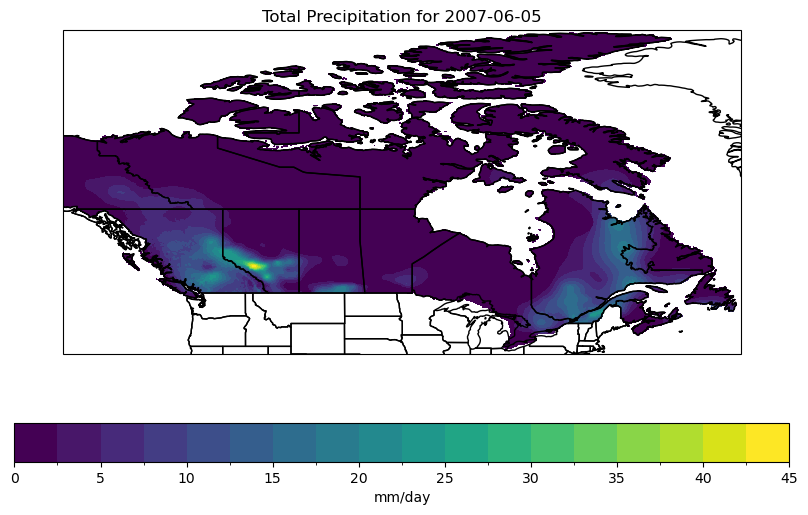

In [3]:
# set up axes with the 'PlateCarree' rectangular coordinate projection for plotting a map
fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(), 
                                         transform = ccrs.PlateCarree()),
                       figsize = (10, 6))

# select the precipitation data for a particular day
sample_time = '2007-06-05'
precip_sample = nrcan_ds.pr.sel(time = sample_time) 

# units of the data are mm/s, but we prefer the standard unit of mm/day so let's convert units
# by multiplying by the number of seconds per day
precip_sample = precip_sample * 3600 * 24

# plot the data with 20 filled contours
precip_sample.plot.contourf(ax = ax, 
                            levels = 20, 
                            cbar_kwargs = {'label': 'mm/day', 'orientation': 'horizontal'}
                            )

# add coastlines to the map so we can easily determine what is land and what is not
# (although this dataset only includes data over land so it won't really make much of a difference)
ax.coastlines()

# add provincial borders and make sure they're plotted on top of the contour data
ax.add_feature(cfeature.STATES, zorder = 1)

# plot title
ax.set_title(f"Total Precipitation for {sample_time}")

plt.show()

## 3.2.3 Analyzing the Data

The above map shows that on the day in question, there was fairly heavy precipitation in Alberta, near Calgary. Let's subset the data in this region so we can analyze it further. 

In [4]:
# subset for Calgary
lat_bnds = [52, 50]
lon_bnds = [-115, -113]

ds_region = nrcan_ds.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds))

# get the precip data for all times
precip = ds_region.pr * 3600 * 24


Error:DAP DATADDS packet is apparently too short


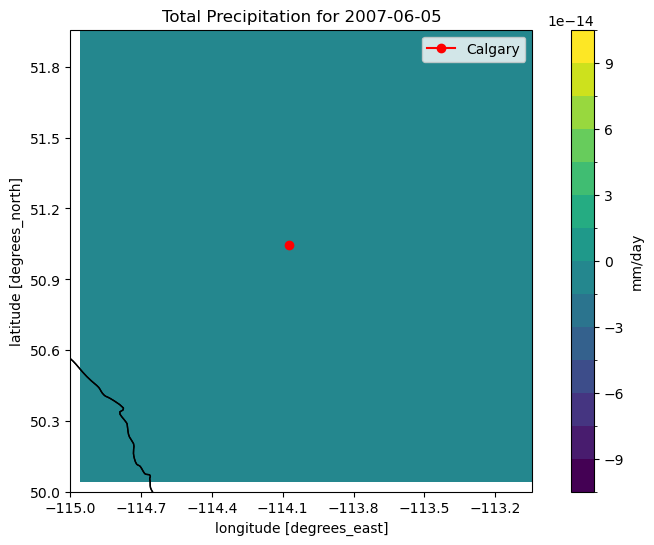

In [5]:
# plot the data on the same day as before
fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(), 
                                         transform = ccrs.PlateCarree()),
                       figsize = (10, 6))

precip.sel(time = sample_time).plot.contourf(ax = ax, 
                                             levels = 20, 
                                             cbar_kwargs = {'label': 'mm/day'})
ax.coastlines()
ax.add_feature(cfeature.STATES, zorder = 1)

# plot the location of Calgary as a dot
lat_cgy = 51.0447
lon_cgy = -114.0719
ax.plot(lon_cgy, lat_cgy, marker = 'o', color = 'r', label = 'Calgary')
ax.legend()

# latitude and longitude ticks
ax.set_xticks(np.arange(*lon_bnds, 0.3))
ax.set_yticks(np.arange(*lat_bnds[::-1], 0.3))

# plot title
ax.set_title(f"Total Precipitation for {sample_time}")
plt.show()

Zooming in around Calgary confirms that there was heavy precipitation there on this particular day - about 27 mm. How does it compare to the 50-year return values for this region? We can calculate this by fitting a GEV distribution to the data for each grid cell. The function ``dask.array.apply_along_axis`` is useful for this, since the ``scipy.stats`` fitting functions work only for 1D data by default.

In [6]:
# annual maximum precip
precip_annmax = precip.resample(time='Y').max()

# fit the GEV distribution at each grid cell - this will return a dask array, which is like a numpy array,
# so it loses the named dimensions
gev_params = dask.array.apply_along_axis(stats.genextreme.fit, 
                                         precip_annmax.get_axis_num('time'),
                                         precip_annmax.data)

# calculate 50-year return period value  - this fuction will automatically do the calculation
# for each grid cell without any
precip_return50 = stats.genextreme.ppf(1 - (1/50), gev_params[0], gev_params[1], gev_params[2])

/Users/mikemorris/opt/anaconda3/envs/UTCDW-env/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:409: RuntimeWarning: invalid value encountered in scalar divide
  return m3 / np.power(m2, 1.5)
/Users/mikemorris/opt/anaconda3/envs/UTCDW-env/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:409: RuntimeWarning: invalid value encountered in scalar divide
  return m3 / np.power(m2, 1.5)


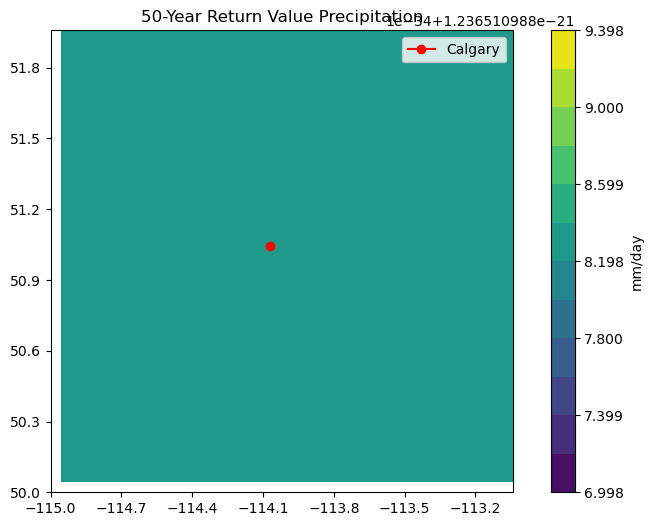

In [7]:
# plot a map of 50-year return values

lons = precip.lon
lats = precip.lat

fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(), 
                                         transform = ccrs.PlateCarree()),
                       figsize = (10, 6))
p = ax.contourf(lons, lats, precip_return50, levels = 15)
fig.colorbar(p, label = 'mm/day')
ax.set_title("50-Year Return Value Precipitation")
lat_cgy = 51.0447
lon_cgy = -114.0719
ax.plot(lon_cgy, lat_cgy, marker = 'o', color = 'r', label = 'Calgary')
ax.legend()

# latitude and longitude ticks
ax.set_xticks(np.arange(*lon_bnds, 0.3))
ax.set_yticks(np.arange(*lat_bnds[::-1], 0.3))

plt.show()

This map tells us that the 50-year return value of precipitation near Calgary is about 65 mm/day, so the event on the day we selected was certainly a lot of rain, but not particularly close to a 50-year event.


## 3.2.4 Other Calculations
Doing the calculation of 50-year return values for gridded data with xarray was a particularly cumbersome task. For most typical calculations, we can do everything with just xarray and numpy, there is usually no need to use ``dask`` directly. Next let's use the pandas-like functionality of xarray to calculate a monthly climatlogy of daily maximum temperature for the Toronto region, to compare to our previous station-based estimates.

In [8]:
# subset for Toronto region
lat_bnds = [45, 42]
lon_bnds = [-81, -78]

ds_region = nrcan_ds.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds))

# daily maximum temperature data for 1992-2021, similar time period to the station analysis
tmax = ds_region.tasmax.sel(time = ds_region.time.dt.year.isin(range(1992, 2022)))

# divide the data into chunks for automatic parallelization of the calculations
tmax = tmax.chunk(chunks='auto')

In [9]:
# calculate monthly climatology - one line of code!
tmax_monthly_clim = tmax.groupby('time.month').mean('time').compute() 

```{note}
Calling `ds.compute()` will trigger computation immediately, and store the numerical results in memory. It can be good to do before plotting results, so it's easier to fix small details of a plot without redoing the computation each time (which can be slow). Only use `ds.compute()` when you're ready to calculate a final result - you don't need to use it for calculating intermediate quantities you won't plot or write to a file.
```

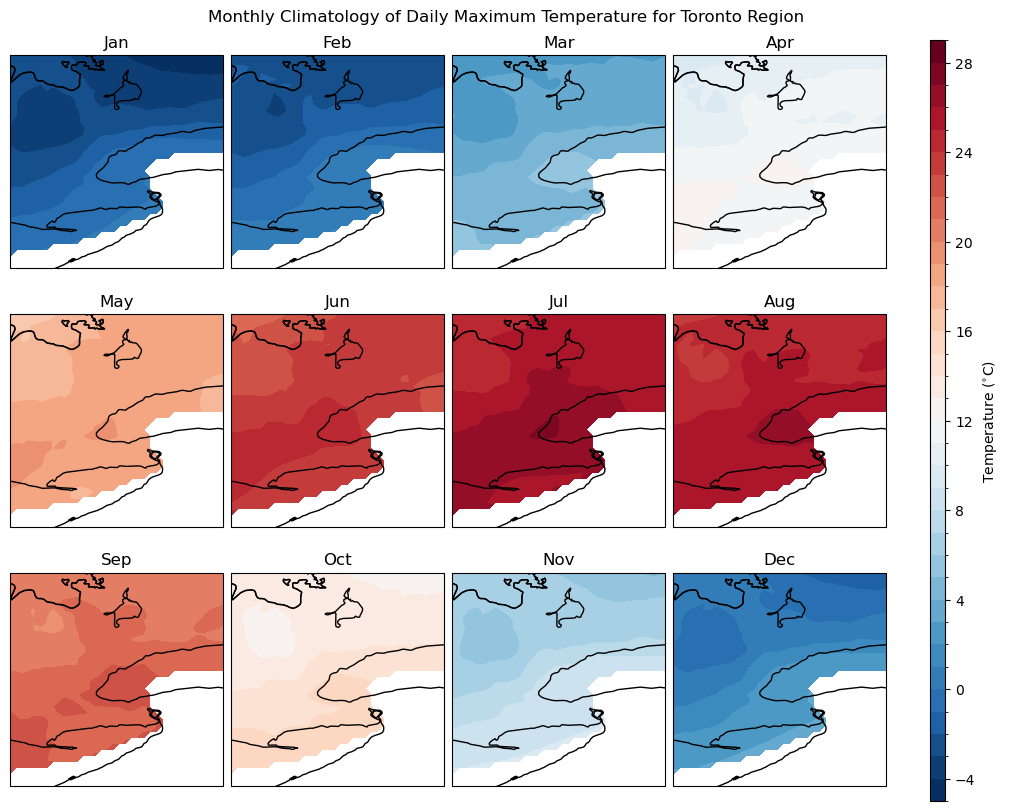

In [10]:
# plot maps in a grid
monthnames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov' ,'Dec']
fig, axes = plt.subplots(nrows = 3, ncols = 4, 
                         constrained_layout = True,
                         figsize = (10,8), 
                         subplot_kw = dict(projection = ccrs.PlateCarree(), 
                                            transform = ccrs.PlateCarree()))
axes_flat = axes.ravel()
for i in range(len(axes_flat)):
    data = tmax_monthly_clim.sel(month = i + 1) - 273.15 # convert from K to Celsius
    p = data.plot.contourf(ax = axes_flat[i], levels = np.arange(-5, 30, 1), add_colorbar = False)
    axes_flat[i].coastlines()
    axes_flat[i].set_title(monthnames[i])
    # plot the Great Lakes
    axes_flat[i].add_feature(cfeature.LAKES, edgecolor = 'black', facecolor = 'none', zorder = 2) 

fig.colorbar(p, ax = axes_flat.tolist(), 
             label = r'Temperature ($^{\circ}$C)', 
             aspect = 50,
             extendrect = True)

fig.suptitle('Monthly Climatology of Daily Maximum Temperature for Toronto Region')

plt.show()

The climatology maps plotted here largely agree with those from the station observations in Section 3.1, which is no surprise since the gridded data here is derived from station observations. This notebook has demonstrated some of the capabilities and limitations of xarray regarding handling climate data. 

A major limitation many observational data products, including gridded data products like the NRCAN ANUSPLIN dataset, is a lack of complete spatial coverage. This this product only includes data for Canada, it is cut off at the border with the United states, which is why the above maps are blank in the southern part of the domain. One solution to this issue regarding spatial coverage is to use **reanalysis** data as a proxy for observations. Reanalysis data will be the subject of the following section.

## 3.2.5 Saving the Data Locally

This notebook has demonstrated some exploratory analysis of the observational data. In your workflow, you're going to want to use this data again later, for model validation, downscaling, and possibly for other types of analysis. Instead of re-loading it from the remote server every time, you can save the data to a netCDF file on your own machine. There are two options for doing this, both will be demonstrated in this subsection. 

### 3.2.5.1 Saving with to_netcdf

If your whole project focuses on a small spatial domain like the one selected for this notebook, then all of the data can be transferred over the OPeNDAP protocol. However, for reasons discussed above, it's a good idea to save the data locally. `xarray` Datasets and DataArrays have a build-in method `to_netcdf()` that will create a netCDF file with a name you specify, and write the data to that file. This is an easy way of saving your data, and it can be applied to any data in `xarray` format. It's especially useful to save the results of time-consuming calculations, so you don't need to re-do the same data processing over and over again. Here we'll save both the raw data and monthly climatology for the daily maximum temperature in the Toronto region, each to their own separate file.

In [11]:
# create a directory to save the output, only if it doesn't already exist
if not os.path.exists("nrcan_data"):
    os.mkdir("nrcan_data")

# write the daily data to a file in the nrcan_data directory we just created, 
# using a file name that describes the contents
tmax.to_netcdf("nrcan_data/tasmax_NRCAN_sontario.1992-2021.nc")

# write the monthly climatology to a file, again using an informative file name
tmax_monthly_clim.to_netcdf("nrcan_data/tasmax_NRCAN_sontario.monthly_clim.1992-2021.nc")

### 3.2.5.1 Downloading Complete Datasets

As mentioned in the preamble to this notebook, only small subsets of the NRCAN observational data can be accessed remotely through OPeNDAP. For most practical uses, you'll need to download and save the data to your own machine. This cannot be done from the PAVICS server due to technical limitations, but you can access this dataset from the [PCIC data portal](https://pacificclimate.org/data) as well (albeit only for the period 1950-2010). More documentation about the PCIC data portal can be found [here](https://data.pacificclimate.org/portal/docs/index.html). 

Below is code for a function that can be used to download the data (it is the same function we'll use in section 3.4 for downloading climate model output from the ESGF archive).

In [12]:
def download(url, filename):
    print("Downloading ", filename)
    r = requests.get(url, stream=True)
    total_size, block_size = int(r.headers.get('content-length', 0)), 1024
    with open(filename, 'wb') as f:
        for data in tqdm(r.iter_content(block_size),
                         total=total_size//block_size,
                         unit='MiB', unit_scale=True):
            f.write(data)
    if total_size != 0 and os.path.getsize(filename) != total_size:
        print("Downloaded size does not match expected size!\n",
              "FYI, the status code was ", r.status_code)

In a similar way to accessing data from a THREDDS server using OPeNDAP, we'll need to load a data catalog from a URL, and parse the results to find the URL for the dataset we want. Let's do that below.

In [13]:
with requests.get("http://tools.pacificclimate.org/dataportal/gridded_observations/catalog/catalog.json") as r:
    datasets = json.loads(r.content)
print(datasets.keys())

dict_keys(['tasmin_day_PCIC_BLEND_v1_historical_19500101-20121231_Canada', 'pr_day_TPS_NWNA_v1_historical_19450101-20121231', 'pr_day_ANUSPLIN_CDA_v2012.1_historical_19500101-20101231', 'pr_day_PCIC_BLEND_v1_historical_19500101-20121231_Canada', 'tasmax_day_TPS_NWNA_v1_historical_19450101-20121231', 'tasmin_day_TPS_NWNA_v1_historical_19450101-20121231', 'tasmin_day_ANUSPLIN_CDA_v2012.1_historical_19500101-20101231', 'tasmax_day_PCIC_BLEND_v1_historical_19500101-20121231_Canada', 'tasmax_day_ANUSPLIN_CDA_v2012.1_historical_19500101-20101231', 'wind_day_TPS_NWNA_v1_historical_19450101-20121231'])


`datasets` is a Python dictionary object, where the keys are the names of each dataset stored in this data catalog. The ones with ANUSPLIN in their name are the NRCAN gridded observations. Unlike PAVICS, each variable is in its own dataset, so if you only want the precipitation data, you don't need to download the daily max and min temperature data as well. 

If you want to download a subset (either spatially or temporally) of the data, you can add an extension to the URL indicating the slices of the data array to access (inclusive of the ending index, which is different from Python-style array slicing). For example the code below will download the first 10 timesteps of the precipitation data, for a 10 $\times$ 20 (lat $\times$ lon) grid cell box somewhere in the domain. To help inform your data selection for spatial regions, it could be helpful to download a sample for a single timestep that covers the whole domain, and then figure out which indicies of the latitude and longitude arrays correspond to the bounding box you desire.

In [14]:
url_download = datasets["pr_day_ANUSPLIN_CDA_v2012.1_historical_19500101-20101231"]
url_download_subset = url_download + "?pr[0:9][150:159][330:349]"
filename_to_write = "nrcan_data/test_NRCAN_download.nc"
download(url_download_subset, filename_to_write)

11.0MiB [00:00, 14.3MiB/s]                                                                                                      


Since this was only a tiny subset of the data (which we could have certainly accessed via OPeNDAP), the download was very quick, but when the subset of the data is larger, it can take over an hour for the download to complete (depending on the volume of data and the speed of your connection). Once completed, you can open the file using `xr.open_dataset()` and manipulate it in exactly the same way as the examples above.

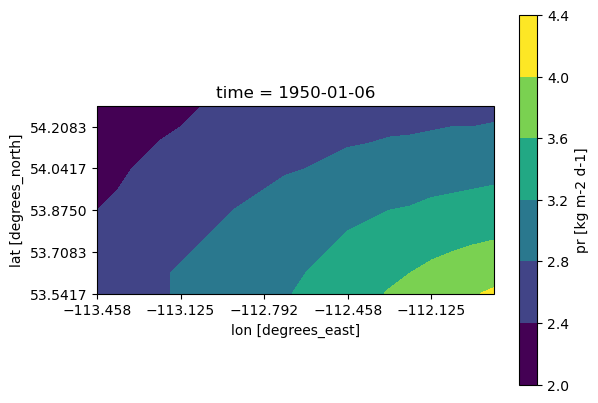

In [15]:
ds_downloaded = xr.open_dataset(filename_to_write)
fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(), 
                                         transform = ccrs.PlateCarree()))
ds_downloaded.pr.isel(time = 5).plot.contourf(ax = ax)
ax.coastlines()
ax.set_xticks(ds_downloaded.lon[::4])
ax.set_yticks(ds_downloaded.lat[::2])
plt.show()

## Appendix: Other gridded observational datasets

The NRCan gridded observations are at daily frequency and include spatial coverage for Canada only - if you require coverage for other regions or sub-daily data, you may be able to find what you're looking for by searching the [NCAR Climate Data Guide](https://climatedataguide.ucar.edu/), or you may need to rely on reanalysis data (described in the next section).

Another commonly used gridded observational dataset, with coverage over southern Canada, the contiguous United States, and Mexico, is the [Livneh dataset](https://doi.org/10.7289/v5x34vf6). Further information about this dataset, how it was created, and how to access it, can be found on its [NCAR Climate Data Guide page](https://climatedataguide.ucar.edu/climate-data/livneh-gridded-precipitation-and-other-meteorological-variables-continental-us-mexico).